In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from collections import Counter
from itertools import islice
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from surprise import Reader, Dataset, accuracy, Reader
from surprise.model_selection import train_test_split
from prettytable import PrettyTable

In [3]:
ratings_dt = pd.read_csv('C:/Users/61450/Desktop/refonte folder/recommendation system/ml-latest-small/ratings.csv')
movie_dt = pd.read_csv('C:/Users/61450/Desktop/refonte folder/recommendation system/ml-latest-small/movies.csv')
ratings_dt.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
ratings_dt.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
ratings_dt['userId'] = ratings_dt['userId'].astype('category')
ratings_dt['movieId'] = ratings_dt['movieId'].astype('category')

In [9]:
ratings_dt.dtypes

userId       category
movieId      category
rating        float64
timestamp       int64
dtype: object

In [11]:
ratings_dt = ratings_dt.drop_duplicates(subset=['userId','movieId','rating','timestamp'], keep='first')
ratings_dt.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [13]:
movie_dt.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [15]:
movie_dt.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [17]:
movie_dt.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [19]:
movie_dt = movie_dt.drop_duplicates(subset=['movieId','title','genres'], keep='first')
movie_dt.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


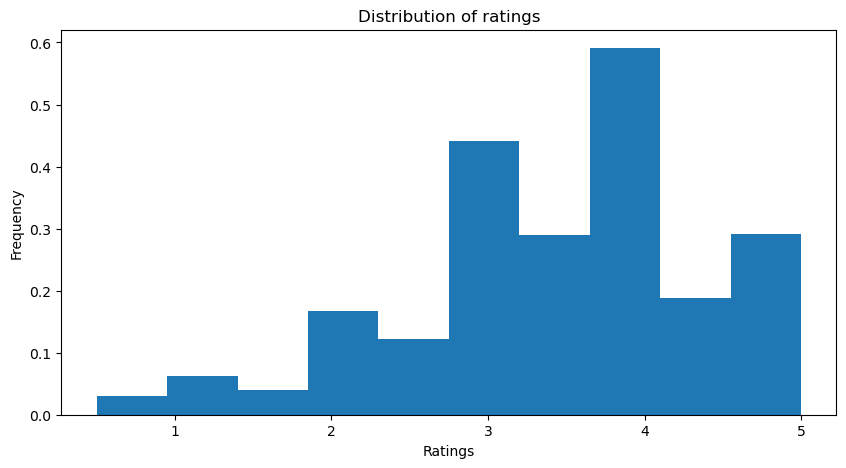

In [21]:
# Distribution of movie ratings

fig = plt.figure(figsize = (10, 5))
plt.hist(ratings_dt['rating'], bins=10, density=True)
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title("Distribution of ratings")
plt.show()

<BarContainer object of 50 artists>

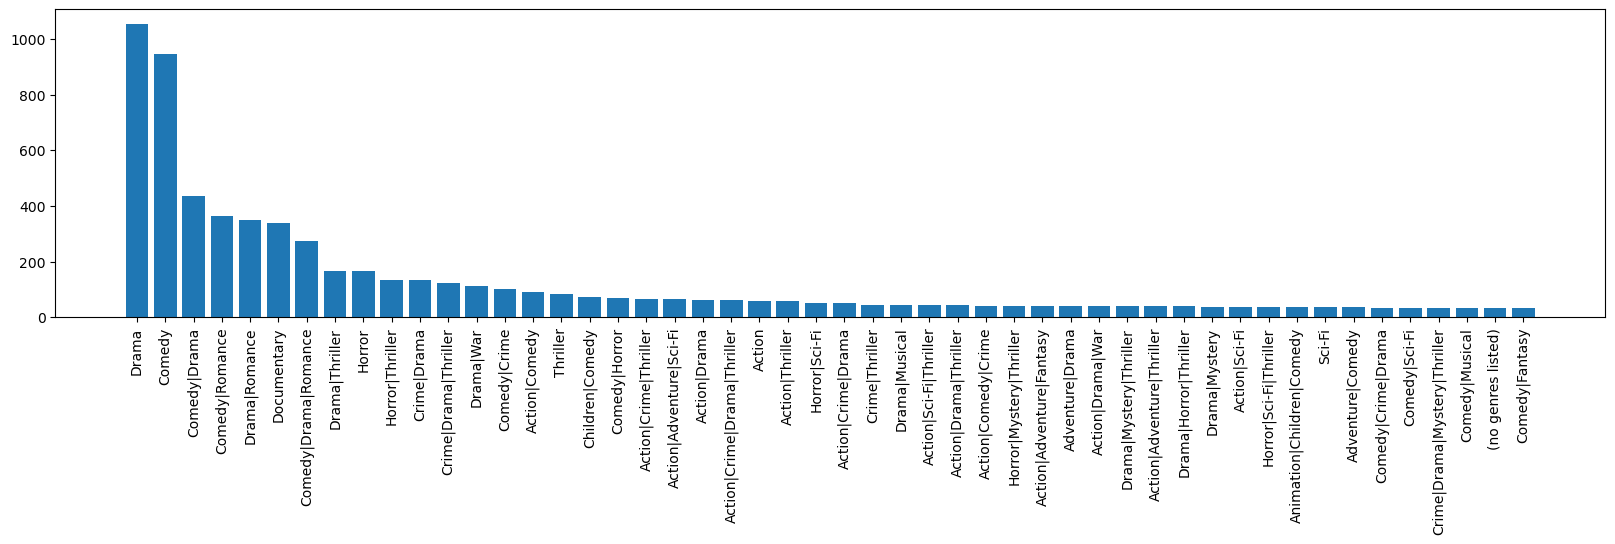

In [22]:
# Distribution of genres 

gen_count= Counter(movie_dt['genres'])
gen_sort = dict(sorted(gen_count.items(), key=lambda item : item[1], reverse=True))
gen_cnt = dict(islice(gen_sort.items(), 50))
fig, ax = plt.subplots(figsize = (20, 4))
ax.set_xticks(ticks=range(50), labels=gen_cnt.keys())
ax.set_xticklabels(labels=gen_cnt.keys(), rotation=90)
plt.bar(gen_cnt.keys(), gen_cnt.values())

In [24]:
# Normalisation of data ratings (0 to 1)

minmax = MinMaxScaler()
rat = minmax.fit_transform(np.array(ratings_dt['rating']).reshape(len(ratings_dt['rating']),1))
ratings_dt['rating'] = pd.DataFrame(rat, columns=['rating'])
ratings_dt['rating']

0         0.777778
1         0.777778
2         0.777778
3         1.000000
4         1.000000
            ...   
100831    0.777778
100832    1.000000
100833    1.000000
100834    1.000000
100835    0.555556
Name: rating, Length: 100836, dtype: float64

In [25]:
# Split genres into categories

genres_lst = []
for m in movie_dt['genres']:
    m = m.split('|')
    genres_lst.append(m)
    
categories = [x for m in genres_lst for x in m]
categor_lst = list(set(categories))
categor_lst

['Action',
 'Crime',
 'Comedy',
 'Horror',
 'Film-Noir',
 '(no genres listed)',
 'Romance',
 'IMAX',
 'Animation',
 'Drama',
 'Musical',
 'Children',
 'Adventure',
 'Mystery',
 'Sci-Fi',
 'Western',
 'War',
 'Documentary',
 'Fantasy',
 'Thriller']

In [26]:
# Add individual category columns to the movies data

new_ct = {}
for i in list(range(len(categor_lst))):
    key = categor_lst[i]
    new_ct.update({key:list(np.zeros(len(movie_dt['genres'])))})

new_categor = pd.DataFrame(new_ct)

pro_movie = pd.concat([movie_dt,new_categor], axis=1)


for i in categor_lst:
    for a in list(range(len(pro_movie['genres']))):
        p = pro_movie.loc[a,'genres']
        p = p.split('|')
        if(i in p):
            pro_movie.loc[a,i]=1
        else:
            pro_movie.loc[a,i]=0  

In [30]:
ratings_dt.to_csv('C:/Users/61450/Desktop/refonte folder/recommendation system/ml-latest-small/preprocessed_ratings.csv')
pro_movie.to_csv('C:/Users/61450/Desktop/refonte folder/recommendation system/ml-latest-small/preprocessed_movies.csv')

In [31]:
ratings_dt = pd.read_csv('C:/Users/61450/Desktop/refonte folder/recommendation system/ml-latest-small/preprocessed_ratings.csv')
movie_dt =   pd.read_csv('C:/Users/61450/Desktop/refonte folder/recommendation system/ml-latest-small/preprocessed_movies.csv')

In [32]:
movie_dt = movie_dt.drop(['Unnamed: 0'], axis=1)
movie_dt.head()

,movieId,title,genres,Action,Crime,Comedy,Horror,Film-Noir,(no genres listed),Romance,...,Musical,Children,Adventure,Mystery,Sci-Fi,Western,War,Documentary,Fantasy,Thriller
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,Grumpier Old Men (1995),Comedy|Romance,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# merging ratings and movie data

rat_mov = pd.merge(ratings_dt,movie_dt, on='movieId')

In [34]:
user_item = pd.pivot_table(rat_mov, values='rating', index=['userId'], columns=['movieId'], fill_value=0)

In [35]:
user_sim = pd.DataFrame(cosine_similarity(user_item, user_item), columns=[rat_mov['userId'].unique()], index=rat_mov['userId'].unique())

In [36]:
#np.save('C:/Users/61450/Desktop/New folder/recommendation system/user_item.npy', user_item)
#user_item = np.load('C:/Users/61450/Desktop/refonte folder/recommendation system/user_item.npy')

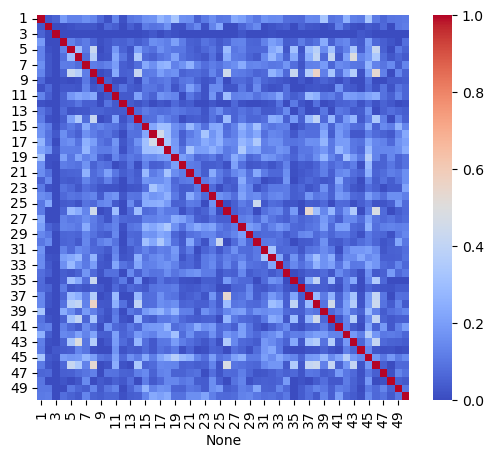

In [37]:
# 1.2 User-User similarity heatmap

plt.figure(figsize = (6,5))
sns.heatmap(user_sim.iloc[:50,:50], cmap = 'coolwarm')
plt.show()

In [38]:
# From the user-user heat map, it is observed that most of the similarities are less than 0.3. There are very few cases
# where user-user similarity is more than 0.4. It is seen that user - user similarity is overall quite low. The threshold
# to find the most similar users will be set at 0.5.

In [67]:
#Function for User based collaborative filtering

def user_user(user_id):
    # Find the most similar users based on similarity (set threshold at 0.5)
    users = user_sim[user_id][user_sim[user_id]>0.8].dropna().index.tolist()
    most_sim_users = rat_mov[rat_mov['userId'].isin(users)].drop(['Unnamed: 0'], axis=1)
    
    if(most_sim_users.empty):  # In case there are no similar users.
        rmse = 'not applicable'
        Precision_at_K = 'not applicable'
        recall_at_K = 'not applicable'
        movies_recom= []
        return(rmse, Precision_at_K, recall_at_K, movies_recom)
        
    else:
        # Average rating for movies watched by most similar users
        mov_av = dict(zip(most_sim_users.movieId.unique(), most_sim_users.groupby('movieId').rating.mean()))
        mov_av_dt = pd.DataFrame(mov_av.items(), columns=['movieId','rating_mean'])
        sorted_movies = mov_av_dt.sort_values('rating_mean', ascending=False)

        #Extract top rated movies watched by most similar users
        top_movies = sorted_movies[sorted_movies['rating_mean']>0.8]
        #top_movies = sorted_movies.head(100)

        #Movies watched by target user
        movies_watched = rat_mov[rat_mov['userId']==user_id]['movieId']

        #Extract movie ids from top rated movies not watched by target user
        mov_id_rec = [m for m in top_movies['movieId'] if m not in movies_watched]

        # Movie titles of recommended movies 
        movies_recom = list(set(rat_mov[rat_mov['movieId'].isin(mov_id_rec)]['title']))

        # RMSE calculation
        #Extract movies from recommended list already watched by target user
        rec_mov_watched = rat_mov[rat_mov['movieId'].isin(top_movies['movieId'])][rat_mov['userId']==user_id] 

         #Create data frame of actual and predicted ratings of movies watched by target user
        act_pred_rat = pd.merge(rec_mov_watched,top_movies,on='movieId')
        
        if(act_pred_rat.empty):
                rmse = 'not applicable'
                Precision_at_K = 'not applicable'
                recall_at_K = 'not applicable'
                return(rmse, Precision_at_K, recall_at_K, movies_recom)
        else:
            rmse = sqrt(mean_squared_error(act_pred_rat['rating'],act_pred_rat['rating_mean']))
            
            #precision (number of relevant items in the top-k recommendations by the total number of recommendations )
            K = len(movies_recom)
            rel_user = rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]
            pr = len([m for m in mov_id_rec if m in rel_user['movieId'].values])
            Precision_at_K = pr/K

            #recall
            K = list(rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]['movieId'].values)
            if (not K):
                recall_at_K = 'not applicable'
            else:
                re = [m for m in K if m in mov_id_rec]
                recall_at_K = len(re)/len(K)

            return(rmse, Precision_at_K, recall_at_K, movies_recom)


In [69]:
item_sim = pd.DataFrame(cosine_similarity(user_item.T,user_item.T), columns=[rat_mov['movieId'].unique()], index=rat_mov['movieId'].unique())

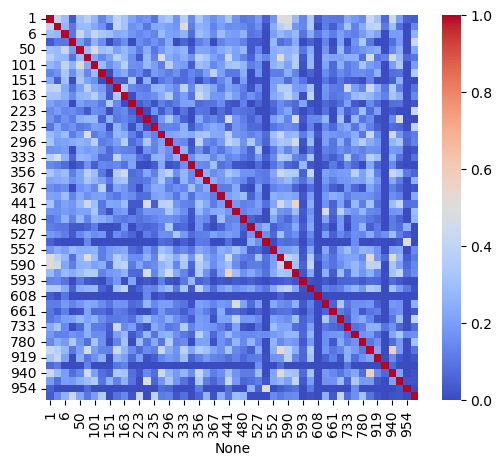

In [70]:
# 2.2 Item item similarity heat map

plt.figure(figsize = (6,5))
sns.heatmap(item_sim.iloc[:50,:50], cmap = 'coolwarm')
plt.show()

In [72]:
#Function for Item based collaborative filtering 

def item_item(user_id):
    
    #Select movies wactched and rated highly by a user (relevant for the user)
    mov_watched_user = rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]['movieId']
    mov_watched_user = list(mov_watched_user)

    # Select movies highly similar to movies watched and rated highly by target user (threshold of item-item similairy = 0.8)
    movid_rec = []
    for movie in mov_watched_user:
        ind =  list(item_sim[movie][item_sim[movie]>0.8].dropna().index)
        ind.remove(movie)
        movid_rec.append(ind)
           
    movid_rec = [m for x in movid_rec for m in x]
    movid_rec = set(movid_rec)
    movid_rec = list(movid_rec)

    if(not movid_rec):
        Precision_at_K = 'not applicable'
        recall_at_K = 'not applicable'
        movies_rec = []
        return(Precision_at_K, recall_at_K, movies_rec)
        
    else:
        movies_rec = movie_dt[movie_dt['movieId'].isin(movid_rec)]['title']
            
        # precision
        K = len(movies_rec)
        rel_user = rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]
        pr = len([m for m in movid_rec if m in rel_user['movieId'].values])
        Precision_at_K = pr/K

        #recall
        K = list(rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]['movieId'].values)
        if (not K):
            recall_at_K = 'not applicable'
        else:
            re = [m for m in K if m in movid_rec]
            recall_at_K = len(re)/len(K)
    
        return(Precision_at_K, recall_at_K, movies_rec)

In [75]:
# 3. Content based recommendation system

# 3.1 Create movie feature matrix

movie_fea = pro_movie.drop(['title','genres','movieId'],axis=1)
movie_fea = movie_fea.to_numpy()

movie_sim = movie_fea.dot(movie_fea.T)
auto_sim = np.sqrt(movie_sim.diagonal())
mov_sim_mat = movie_sim/(auto_sim[np.newaxis,:]*auto_sim[:,np.newaxis])

mov_sim_df = pd.DataFrame(mov_sim_mat, columns=[movie_dt['movieId']], index=movie_dt['movieId'])
mov_sim_df

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.774597,0.316228,0.258199,0.447214,0.000000,0.316228,0.632456,0.000000,0.258199,...,0.447214,0.316228,0.316228,0.447214,0.0,0.670820,0.774597,0.00000,0.316228,0.447214
2,0.774597,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.816497,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.0,0.288675,0.333333,0.00000,0.000000,0.000000
3,0.316228,0.000000,1.000000,0.816497,0.707107,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.353553,0.000000,0.500000,0.000000,0.0,0.353553,0.408248,0.00000,0.000000,0.707107
4,0.258199,0.000000,0.816497,1.000000,0.577350,0.000000,0.816497,0.000000,0.000000,0.000000,...,0.288675,0.408248,0.816497,0.000000,0.0,0.288675,0.333333,0.57735,0.000000,0.577350
5,0.447214,0.000000,0.707107,0.577350,1.000000,0.000000,0.707107,0.000000,0.000000,0.000000,...,0.500000,0.000000,0.707107,0.000000,0.0,0.500000,0.577350,0.00000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.670820,0.288675,0.353553,0.288675,0.500000,0.288675,0.353553,0.000000,0.500000,0.288675,...,0.750000,0.353553,0.353553,0.500000,0.0,1.000000,0.866025,0.00000,0.707107,0.500000
193583,0.774597,0.333333,0.408248,0.333333,0.577350,0.000000,0.408248,0.000000,0.000000,0.000000,...,0.577350,0.408248,0.408248,0.577350,0.0,0.866025,1.000000,0.00000,0.408248,0.577350
193585,0.000000,0.000000,0.000000,0.577350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.707107,0.707107,0.000000,0.0,0.000000,0.000000,1.00000,0.000000,0.000000


In [76]:
#Function for content based filtering (more compact form)

def content_based(user_id):
    #Select movies wactched and rated highly by a user (relevant for the user)
    mov_watched_user = rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]['movieId']
    mov_watched_user = list(mov_watched_user)

   # Select movies highly similar to movies watched or rated highly by target user (threshold of item-item similairy = 0.8)
    movid_rec = []
    for movie in mov_watched_user:
        ind =  list(mov_sim_df[movie][mov_sim_df[movie]>0.9].dropna().index)
        ind.remove(movie)
        movid_rec.append(ind)
           
    movid_rec = [m for x in movid_rec for m in x]
    movid_rec = set(movid_rec)
    movid_rec = list(movid_rec)

    if(not movid_rec):
        Precision_at_K = 'not applicable'
        recall_at_K = 'not applicable'
        movies_rec = []
        return(Precision_at_K, recall_at_K, movies_rec)
    else:
        movies_rec = movie_dt[movie_dt['movieId'].isin(movid_rec)]['title']
            
        # precision
        K = len(movies_rec)
        rel_user = rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]
        pr = len([m for m in movid_rec if m in rel_user['movieId'].values])
        Precision_at_K = pr/K

        #recall
        K = list(rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]['movieId'].values)
        if (not K):
            recall_at_K = 'not applicable'
        else:
            re = [m for m in K if m in movid_rec]
            recall_at_K = len(re)/len(K)
    
        return(Precision_at_K, recall_at_K, movies_rec)

In [77]:
# To address the cold start problem, a new user may be asked about favourite genre. The highly rated genre/genres can be used to select 
# movies of the same content (content based filtering). Movies based on favourite genre can be further used to select and more movies by using
# item based collaborative filtering. Here, user based filtering cannot be used due to a lack of user watch history.

In [78]:
# Hybrid model (cascading approach)
# Combine recommended movies from user and item based filtering (union of movie ids)
# Use the recommended list from collaborative filtering to select movies similar in content to the movies and highly rated by the target user 
# Combine the recommended lists from collaborative and content based filtering

def hybrid_cascade(user_id, movie_userbased, movie_itembased):
    movieid_user = movie_dt[movie_dt['title'].isin(movie_userbased)]['movieId']  #movie ids from user based collaborative filtering
    movieid_item = movie_dt[movie_dt['title'].isin(movie_itembased)]['movieId']  #movie ids from item based collaborative filtering
    mov_collab = list(set(movieid_user).union(set(movieid_item)))  #combined list

     #Select movies wactched and rated highly by a user (relevant for the user)
    mov_watched_user = rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]['movieId']
    mov_watched_user = list(mov_watched_user)
         
    # Select movies highly similar to movies watched or rated highly by target user (threshold of item-item similairy = 0.8)
    movid_rec = []
    for movie in mov_watched_user:
        ind =   list(mov_sim_df[movie][mov_sim_df[movie]>0.8].dropna().index)
        ind.remove(movie)
        movid_rec.append(ind)
           
    movid_rec = [m for x in movid_rec for m in x]
    movid_rec = set(movid_rec)
    movid_rec = list(movid_rec)

    rec_mov_id = [m for m in mov_collab if m in movid_rec]
    rec_mov = movie_dt[movie_dt['movieId'].isin(rec_mov_id)]['title']

    if(not rec_mov_id):
        Precision_at_K = 'not applicable'
        recall_at_K = 'not applicable'
        movies_rec = []
        return(Precision_at_K, recall_at_K, rec_mov)
    else:
        #Precision@K 
        K = len(rec_mov_id)
        rel_user = rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]
        pr = len([m for m in rec_mov_id if m in rel_user['movieId'].values])
        Precision_at_K = pr/K

        #recall
        K = list(rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]['movieId'].values)
        if (not K):
             recall_at_K = 'not applicable'
        else:
            re = [m for m in K if m in rec_mov_id]
            recall_at_K = len(re)/len(K)

        return(Precision_at_K, recall_at_K, rec_mov)

In [82]:
# Hybrid model (stacking recommendations approach)
# Stack predictions from  collaborative and content based filtering

def hybrid_stacking(user_id, mov_userbased, mov_itembased, mov_content):
    movieid_user = movie_dt[movie_dt['title'].isin(mov_userbased)]['movieId']  #movie ids from user based collaborative filtering
    movieid_item = movie_dt[movie_dt['title'].isin(mov_itembased)]['movieId']  #movie ids from item based collaborative filtering
    movieid_content = movie_dt[movie_dt['title'].isin(mov_content)]['movieId']   #movie ids from content based filtering
    
    mov_collab = list(set(movieid_user).union(set(movieid_item)))
    
    final_rec_movid = list(set(mov_collab).union(set(movieid_content)))  #recommended list hybrid model
    final_rec_movies = movie_dt[movie_dt['movieId'].isin(final_rec_movid)]['title']

    if(not final_rec_movid):
        Precision_at_K = 'not applicable'
        recall_at_K = 'not applicable'
        final_rec_movies = []
        return(Precision_at_K, recall_at_K, final_rec_movies)
    else:
        #Precision@K 
        K = len(final_rec_movid)
        rel_user = rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]
        pr = len([m for m in final_rec_movid if m in rel_user['movieId'].values])
        Precision_at_K = pr/K

        #recall
        K = list(rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]['movieId'].values)
        if (not K):
            recall_at_K = 'not applicable'
        else:
            re = [m for m in K if m in final_rec_movid]
            recall_at_K = len(re)/len(K)
    
        return(Precision_at_K, recall_at_K, final_rec_movies)

In [85]:
movie_fea = pro_movie.drop(['title','genres'],axis=1)

In [87]:
# SVD approach

reader = Reader(rating_scale=(0,1))
dt = Dataset.load_from_df(rat_mov[['userId','movieId','rating']], reader=reader)
train_dt, test_dt = train_test_split(dt, test_size=0.3, random_state=42)
model = SVD()
model.fit(train_dt)
predictions = model.test(test_dt)
accuracy.rmse(predictions)

RMSE: 0.2014


0.20142848044340209

In [88]:
def svd_rec(user_id):
    item_ids = movie_dt['movieId'].values
    rec_list = {}
    for item in item_ids:
        rec_list.update({item: model.predict(user_id,item).est})

    rec_list_dt = dict(sorted(rec_list.items(), key=lambda x:x[1], reverse=True))
    rec_movieId = {k:v for k,v in rec_list_dt.items() if v>0.8}
    rec_movies = movie_dt[movie_dt['movieId'].isin(rec_movieId.keys())]['title']

    if(not rec_movieId):
        Precision_at_K = 'not applicable'
        recall_at_K = 'not applicable'
        rec_movies = []
        return(Precision_at_K, recall_at_K, rec_movies)
    else:
        #Precision@K 
        K = len(rec_movieId)
        rel_user = rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]
        pr = len([m for m in rec_movieId if m in rel_user['movieId'].values])
        Precision_at_K = pr/K

        #recall
        K = list(rat_mov[rat_mov['userId']==user_id][rat_mov['rating']>0.8]['movieId'].values)
        if (not K):
            recall_at_K = 'not applicable'
        else:
            re = [m for m in K if m in rec_movieId]
            recall_at_K = len(re)/len(K)
    
        return(Precision_at_K, recall_at_K, rec_movies)

In [191]:
user_input = int(input('Enter user id:'))

#User user collaborative filtering
rmse1, Precision_at_K_1, recall_at_K_1, recom_movie_user = user_user(user_input)

#item item collaborative filtering
Precision_at_K_2, recall_at_K_2, recom_movie_item = item_item(user_input)

#content based filtering
Precision_at_K_3, recall_at_K_3, recom_movie_content = content_based(user_input)

#Hybrid model cascading approach   
Precision_at_K_4, recall_at_K_4, recom_movie_hybcas = hybrid_cascade(user_input, recom_movie_user, recom_movie_item)

#Hybrid model stacking predictions

Precision_at_K_5, recall_at_K_5, recom_movieId_hybsta = hybrid_stacking(user_input, recom_movie_user, recom_movie_item, recom_movie_content)

Precision_at_K_6, recall_at_K_6, recom_movies = svd_rec(user_input)

Enter user id: 72


In [193]:
#Model comparison

table = PrettyTable()
table.field_names = ["Model name", "Precision", "Recall"]

if (type(Precision_at_K_1) == str or type(recall_at_K_1) == str):
    table.add_row(["user-user colaborative filtering", Precision_at_K_1, recall_at_K_1])
else:
    table.add_row(["user-user colaborative filtering", round(Precision_at_K_1,4), round(recall_at_K_1,4)])

if (type(Precision_at_K_2) == str or type(recall_at_K_2) == str):
    table.add_row(["item-item colaborative filtering", Precision_at_K_2, recall_at_K_2])
else:
    table.add_row(["item-item colaborative filtering", round(Precision_at_K_2,4), round(recall_at_K_2,4)])

if (type(Precision_at_K_3) == str or type(recall_at_K_3) == str):
    table.add_row(["content based colaborative filtering", Precision_at_K_3, recall_at_K_3])
else:
    table.add_row(["content based colaborative filtering", round(Precision_at_K_3,4), round(recall_at_K_3,4)])

if (type(Precision_at_K_4) == str or type(recall_at_K_4) == str):
    table.add_row(["hybrid cascading based colaborative filtering", Precision_at_K_4, recall_at_K_4])
else:
    table.add_row(["hybrid cascading based colaborative filtering", round(Precision_at_K_4,4), round(recall_at_K_4,4)])

if (type(Precision_at_K_5) == str or type(recall_at_K_5) == str):
    table.add_row(["hybrid stacking based colaborative filtering", Precision_at_K_5, recall_at_K_5])
else:
    table.add_row(["hybrid stacking based colaborative filtering", round(Precision_at_K_5,4), round(recall_at_K_5,4)])

if (type(Precision_at_K_6) == str or type(recall_at_K_6) == str):
    table.add_row(["SVD colaborative filtering", Precision_at_K_6, recall_at_K_6])
else:
    table.add_row(["SVD colaborative filtering", round(Precision_at_K_6,4), round(recall_at_K_6,4)])

In [195]:
# model comparison
table

Model name,Precision,Recall
user-user colaborative filtering,1.0,1.0
item-item colaborative filtering,0.0,0.0
content based colaborative filtering,0.0083,0.4783
hybrid cascading based colaborative filtering,0.8571,0.7826
hybrid stacking based colaborative filtering,0.0169,1.0
SVD colaborative filtering,0.0091,0.913


In [205]:
# In this movie recommendation system, a target user was selected and movies were recommended by using different approaches 
# viz. user based and item based collaborative filtering, content based filtering and hybrid model. To simplify the process of movie recommendation, the data was not split into train and 
# test data. The whole data was used for analysing user preferences and movie features. 

In [207]:
# It is observed that model performance differs from one user to another. However, hybrid models overall deliver better
# results than the individual models, especially in recall@K. The hybrid model can generate more number of relevant 
# items from the recommended list. The performance of each individual model also depends on threshold in user-user similarity and item-item similarity.
# A higher threshold gives a clearer picture of the effectiveness of a recommendation method.

In [209]:
# User based collaborative filtering: Is quite useful when a user has a watch history and shares similar interests with 
#                                     many other users. However, the method is not feasable for a new user or for a user 
#                                     whose preferences do not match with those of the other users.

# Item based collaborative filtering: Is implemented when an item has already been used by many users. So it is easy to extract similar items
#                                     based on the number of common users and similar ratings given by the same users. Item based
#                                     collaborative filtering cannot be used for a new item. In such cases, the content or the item features
#                                     should be analysed to find the most similar items and the users who rated them highly. Item based is also not 
#                                     effective if item-item similarity is low.

# Content based filtering approach: Content based approach is useful in addressing the cold start problem where weither the user or item is
#                                    new. The new user can be recommended items based on one's preferences in features/genre that the user selected
#                                    for the first time. It helps offer a more personalised service to the users. Similarly, a new item can be 
#                                     offered to the existing users whose preferences match with the item features.

# Hybrid (cascading)approach: In one hybrid approach, the recommended items from collaborative filtering were passed thorugh content based filtering 
#                             to find more items similar in content/features. The idea behind this approach is to offer more choices to the target user.
#                             The underlying assumption of this approach is that the user or the item is not new and shares similarity with many 
#                              other users or items based on the usage history. It is also assumed that collaborative filtering will generate 
#                              a list of movies in alignment with the user interests.

# Hybrid (stacking) approach: In this approach, the recomended items from both collaborative and content based filtering are combined. Here, an equal
#                            weightage is given to both the approaches and all the top recommended movies are selected from all methods. This method
#                            can also generate results for a cold start problem where content based approach alone can recommend movies to a new user.

In [211]:
# Evaluation metrics:

# Precision@K: It is used to find the ratio of relevant items from the recommended list to the number of recommended items. The evaluation
#              metric can be used to test a recommendation system only when a user actually watches a movie from the recommended list and gives it a
#              high rating. Higher the precision, more robust the recommendation system. However, precision is not an effective metric if a user 
#              has watched and rated very few movies from the recommended list. It is difficult to assess the robustness in case of low precision, 
#              as the user's opinions about most of the other movies is not known.

# Recall@K: Is a useful metric in determing if the recommended list offers only relevant items to the target user. 

# RMSE: The metric is useful only when the actual user ratings are known and there is a high similarity between a target user and its similar users.
#        In case of low user-user similarity, the predicted movie ratings will not be a good estimate of the actual ratings. RMSE also cannot be
#        used for a new user.

In [213]:
# Final recommended list by combining all models

In [209]:
final_list = list(recom_movie_user) + list(recom_movie_item) + list(recom_movie_content) + list(recom_movie_hybcas) + list(recom_movieId_hybsta) + list(recom_movies) 

In [211]:
final_list = set(final_list)

In [217]:
list(final_list)[:20]

['True Romance (1993)',
 'Elf (2003)',
 'Villain (1971)',
 'Hellbenders (2012)',
 'Ref, The (1994)',
 'Blades of Glory (2007)',
 'Lords of Salem, The (2012)',
 'Elizabeth: The Golden Age (2007)',
 'Willy/Milly (1986)',
 'Milk (2008)',
 "What's Eating Gilbert Grape (1993)",
 'Birth of a Nation, The (1915)',
 'Adventures of Robin Hood, The (1938)',
 'Father of the Bride (1991)',
 'Washington Square (1997)',
 'Thomas Crown Affair, The (1968)',
 'Ninja Scroll (Jûbei ninpûchô) (1995)',
 'Anne Frank Remembered (1995)',
 'Django Unchained (2012)',
 'Love and Death (1975)']